<a href="https://colab.research.google.com/github/pmugabo/Group-7-Malaria-Diagnosis-CNN-Transfer-Learning/blob/main/Malaria_Diagnosis_CNN_Group6_EvenNumber.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning for Malaria Diagnosis
This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018) and (Jason Brownlee, 2019). Acknowledge to NIH and Bangalor Hospital who make available this malaria dataset.

Malaria is an infectuous disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes.

The Malaria burden with some key figures:
<font color='red'>
* More than 219 million cases
* Over 430 000 deaths in 2017 (Mostly: children & pregnants)
* 80% in 15 countries of Africa & India
  </font>

![MalariaBurd](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaBurden.png?raw=1)

The malaria diagnosis is performed using blood test:
* Collect patient blood smear
* Microscopic visualisation of the parasit

![MalariaDiag](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/MalariaDiag.png?raw=1)
  
Main issues related to traditional diagnosis:
<font color='#ed7d31'>
* resource-constrained regions
* time needed and delays
* diagnosis accuracy and cost
</font>

The objective of this notebook is to apply modern deep learning techniques to perform medical image analysis for malaria diagnosis.

*This notebook is inspired by works of (Sivaramakrishnan Rajaraman  et al., 2018), (Adrian Rosebrock, 2018) and (Jason Brownlee, 2019)*

## Configuration

In [1]:
#Mount the local drive project_forder
from google.colab import drive
drive.mount('/content/drive/')
!ls "/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/"

Mounted at /content/drive/
ls: cannot access '/content/drive/My Drive/Colab Notebooks/10xDS/Projects/malaria-diagnosis/': No such file or directory


In [2]:
# Use GPU: Please check if the outpout is '/device:GPU:0'
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()
#from tensorflow.python.client import device_lib
#device_lib.list_local_devices()

2.19.0


'/device:GPU:0'

## Populating namespaces

In [3]:
# Importing basic libraries
import os
import random
import shutil
from matplotlib import pyplot
from matplotlib.image import imread
%matplotlib inline

# Importing the Keras libraries and packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D as Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

In [4]:
# Define the useful paths for data accessibility
ai_project = '.' #"/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
cell_images_dir = os.path.join(ai_project,'cell_images')
training_path = os.path.join(ai_project,'train')
testing_path = os.path.join(ai_project,'test')

## Prepare DataSet

### *Download* DataSet

In [5]:
# Download the data in the allocated google cloud-server. If already down, turn downloadData=False
downloadData = True
if downloadData == True:
  indrive = False
  if indrive == True:
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip -P "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
    !unzip "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/cell_images.zip" -d "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis/"
    !ls "/content/drive/My Drive/Colab Notebooks/ai-labs/malaria-diagnosis"
  else: #incloud google server
    !rm -rf cell_images.*
    !wget https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
    !unzip cell_images.zip >/dev/null 2>&1
    !ls

--2025-10-05 20:45:49--  https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip
Resolving data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)... 3.167.192.111, 3.167.192.56, 3.167.192.60, ...
Connecting to data.lhncbc.nlm.nih.gov (data.lhncbc.nlm.nih.gov)|3.167.192.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 353452851 (337M) [application/zip]
Saving to: ‘cell_images.zip’

cell_images.zip     100%[===================>] 337.08M  57.0MB/s    in 3.5s    

2025-10-05 20:45:52 (95.8 MB/s) - ‘cell_images.zip’ saved [353452851/353452851]

cell_images  cell_images.zip  drive  sample_data


## Baseline CNN Model
Define a basic ConvNet defined with ConvLayer: Conv2D => MaxPooling2D followed by Flatten => Dense => Dense(output)

![ConvNet](https://github.com/habiboulaye/ai-labs/blob/master/malaria-diagnosis/doc-images/ConvNet.png?raw=1)


## Advanced CNN (Student Contribution)
This section implements an improved CNN using deeper blocks, data augmentation, and regularization. It also includes utilities to load data with `tf.data`, run multiple experiments, and generate evaluation visuals (learning curves, confusion matrix, ROC/AUC).


In [3]:
# Imports and utility functions for the advanced CNN section
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc

# Reproducibility
SEED = 42
np.random.seed(SEED)

tf.keras.utils.set_random_seed(SEED)

def get_datasets(data_dir: str = 'cell_images',
                 image_size: Tuple[int, int] = (128, 128),
                 batch_size: int = 32,
                 val_split: float = 0.2,
                 shuffle: bool = True) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset, Dict]:
    """Create train/val/test datasets using keras utils with caching and prefetching.
    Assumes directory structure with two subfolders (e.g., Parasitized/Uninfected).
    If a distinct test folder exists at 'test', it will be loaded; otherwise splits from training.
    """
    data_dir = os.path.abspath(data_dir)
    train_dir = os.path.join(os.path.dirname(data_dir), 'train')
    test_dir = os.path.join(os.path.dirname(data_dir), 'test')

    if os.path.isdir(train_dir) and os.path.isdir(test_dir):
        train_ds = keras.utils.image_dataset_from_directory(
            train_dir,
            labels='inferred',
            label_mode='int',
            batch_size=batch_size,
            image_size=image_size,
            validation_split=val_split,
            subset='training',
            seed=SEED,
            shuffle=shuffle
        )
        val_ds = keras.utils.image_dataset_from_directory(
            train_dir,
            labels='inferred',
            label_mode='int',
            batch_size=batch_size,
            image_size=image_size,
            validation_split=val_split,
            subset='validation',
            seed=SEED,
            shuffle=shuffle
        )
        test_ds = keras.utils.image_dataset_from_directory(
            test_dir,
            labels='inferred',
            label_mode='int',
            batch_size=batch_size,
            image_size=image_size,
            shuffle=False
        )
    else:
        # Fallback to splitting from a single data_dir
        train_ds = keras.utils.image_dataset_from_directory(
            data_dir,
            labels='inferred',
            label_mode='int',
            batch_size=batch_size,
            image_size=image_size,
            validation_split=val_split,
            subset='training',
            seed=SEED,
            shuffle=shuffle
        )
        val_ds = keras.utils.image_dataset_from_directory(
            data_dir,
            labels='inferred',
            label_mode='int',
            batch_size=batch_size,
            image_size=image_size,
            validation_split=val_split,
            subset='validation',
            seed=SEED,
            shuffle=shuffle
        )
        test_ds = val_ds

    class_names = train_ds.class_names

    # Cache + prefetch for performance
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(AUTOTUNE)
    val_ds = val_ds.cache().prefetch(AUTOTUNE)
    test_ds = test_ds.cache().prefetch(AUTOTUNE)

    meta = {
        'class_names': class_names,
        'num_classes': len(class_names),
        'image_size': image_size,
    }
    return train_ds, val_ds, test_ds, meta


def build_advanced_cnn(input_shape=(128, 128, 3), num_classes: int = 2,
                        dropout_rate: float = 0.4,
                        l2_weight: float = 1e-4,
                        base_filters: int = 32,
                        use_batchnorm: bool = True) -> keras.Model:
    """Deeper CNN with regularization and optional BatchNorm."""
    WeightDecay = keras.regularizers.l2(l2_weight) if l2_weight else None

    inputs = keras.Input(shape=input_shape)

    data_augmentation = keras.Sequential([
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
    ], name='augmentation')

    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255)(x)

    def conv_block(x, filters, kernel_size=3):
        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=WeightDecay)(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=WeightDecay)(x)
        if use_batchnorm:
            x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPooling2D()(x)
        x = layers.SpatialDropout2D(0.1)(x)
        return x

    x = conv_block(x, base_filters)
    x = conv_block(x, base_filters * 2)
    x = conv_block(x, base_filters * 4)

    x = layers.Conv2D(base_filters * 8, 3, padding='same', kernel_regularizer=WeightDecay)(x)
    if use_batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(max(64, base_filters * 2), activation='relu', kernel_regularizer=WeightDecay)(x)
    x = layers.Dropout(dropout_rate)(x)

    if num_classes == 2:
        outputs = layers.Dense(1, activation='sigmoid')(x)
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs, name='AdvancedCNN')
    return model


def compile_model(model: keras.Model, lr: float = 1e-3, num_classes: int = 2):
    if num_classes == 2:
        loss = 'binary_crossentropy'
        metrics = [
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    else:
        loss = 'sparse_categorical_crossentropy'
        metrics = [
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=loss, metrics=metrics)


def plot_learning_curves(history: keras.callbacks.History, title: str = 'Learning Curves', savepath: str = None):
    h = history.history
    epochs = range(1, len(h['loss']) + 1)
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(epochs, h['loss'], label='train')
    if 'val_loss' in h:
        axs[0].plot(epochs, h['val_loss'], label='val')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    if 'accuracy' in h:
        axs[1].plot(epochs, h['accuracy'], label='train')
        if 'val_accuracy' in h:
            axs[1].plot(epochs, h['val_accuracy'], label='val')
        axs[1].set_title('Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()
    plt.suptitle(title)
    if savepath:
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
    plt.show()


def evaluate_and_plots(model: keras.Model, ds: tf.data.Dataset, num_classes: int, class_names: list, title_prefix: str = 'Advanced CNN', save_prefix: str = None) -> Dict:
    y_true = []
    y_prob = []
    x_store = []
    for images, labels in ds:
        preds = model.predict(images, verbose=0)
        if num_classes == 2:
            y_prob.extend(preds.flatten())
            y_true.extend(labels.numpy().astype(int))
        else:
            y_prob.extend(tf.nn.softmax(preds, axis=-1).numpy())
            y_true.extend(labels.numpy().astype(int))
        x_store.append(images.numpy())

    y_true = np.array(y_true)
    X = np.concatenate(x_store, axis=0) if x_store else None
    if num_classes == 2:
        y_prob_arr = np.array(y_prob)
        y_pred = (y_prob_arr >= 0.5).astype(int)
        acc = (y_pred == y_true).mean()
        prec = 0.0 if (y_pred.sum() == 0) else ( ( (y_pred & (y_true==1)).sum() ) / max(1, y_pred.sum()) )
        rec = 0.0 if ((y_true==1).sum() == 0) else ( ( (y_pred & (y_true==1)).sum() ) / max(1, (y_true==1).sum()) )
        f1 = 0.0 if (prec+rec)==0 else 2*prec*rec/(prec+rec)
        try:
            roc_auc = roc_auc_score(y_true, y_prob_arr)
        except ValueError:
            roc_auc = float('nan')
        cm = confusion_matrix(y_true, y_pred)

        # Normalized confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fig, ax = plt.subplots(1,2, figsize=(9,4))
        im0 = ax[0].imshow(cm, cmap='Blues')
        ax[0].set_title(f'{title_prefix} - Confusion Matrix')
        ax[0].set_xticks([0,1]); ax[0].set_xticklabels(class_names)
        ax[0].set_yticks([0,1]); ax[0].set_yticklabels(class_names)
        for (i, j), v in np.ndenumerate(cm):
            ax[0].text(j, i, str(v), ha='center', va='center')
        plt.colorbar(im0, ax=ax[0])

        im1 = ax[1].imshow(cm_norm, cmap='Greens', vmin=0, vmax=1)
        ax[1].set_title('Normalized CM')
        ax[1].set_xticks([0,1]); ax[1].set_xticklabels(class_names)
        ax[1].set_yticks([0,1]); ax[1].set_yticklabels(class_names)
        for (i, j), v in np.ndenumerate(cm_norm):
            ax[1].text(j, i, f'{v:.2f}', ha='center', va='center')
        plt.colorbar(im1, ax=ax[1])
        if save_prefix:
            plt.savefig(f"{save_prefix}_cm.png", bbox_inches='tight', dpi=150)
        plt.show()

        # ROC curve
        try:
            fpr, tpr, _ = roc_curve(y_true, y_prob_arr)
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, label=f'AUC={auc(fpr, tpr):.3f}')
            plt.plot([0,1], [0,1], 'k--')
            plt.xlabel('FPR'); plt.ylabel('TPR')
            plt.title(f'{title_prefix} - ROC Curve')
            plt.legend()
            if save_prefix:
                plt.savefig(f"{save_prefix}_roc.png", bbox_inches='tight', dpi=150)
            plt.show()
        except ValueError:
            pass

        # Precision-Recall curve
        try:
            from sklearn.metrics import precision_recall_curve
            precision_points, recall_points, _ = precision_recall_curve(y_true, y_prob_arr)
            plt.figure(figsize=(5,4))
            plt.plot(recall_points, precision_points)
            plt.xlabel('Recall'); plt.ylabel('Precision')
            plt.title(f'{title_prefix} - Precision-Recall')
            if save_prefix:
                plt.savefig(f"{save_prefix}_pr.png", bbox_inches='tight', dpi=150)
            plt.show()
        except Exception:
            pass

        # Misclassified grid
        if X is not None:
            wrong_idx = np.where(y_pred != y_true)[0][:16]
            if len(wrong_idx) > 0:
                cols = 4; rows = int(math.ceil(len(wrong_idx)/cols))
                plt.figure(figsize=(12, 3*rows))
                for i, idx in enumerate(wrong_idx):
                    plt.subplot(rows, cols, i+1)
                    plt.imshow(X[idx].astype('uint8'))
                    plt.axis('off')
                    plt.title(f'T:{class_names[y_true[idx]]}\nP:{class_names[y_pred[idx]]}')
                plt.suptitle(f'{title_prefix} - Misclassified Samples')
                if save_prefix:
                    plt.savefig(f"{save_prefix}_miscls.png", bbox_inches='tight', dpi=150)
                plt.show()

        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1': f1,
            'roc_auc': roc_auc,
            'confusion_matrix': cm
        }
    else:
        y_prob = np.array(y_prob)
        y_pred = y_prob.argmax(axis=1)
        acc = (y_pred == y_true).mean()
        cm = confusion_matrix(y_true, y_pred)
        report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
        f1_macro = report['macro avg']['f1-score']

        # Normalized confusion matrix
        cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        im0 = ax[0].imshow(cm, cmap='Blues')
        ax[0].set_title(f'{title_prefix} - Confusion Matrix')
        ax[0].set_xticks(range(len(class_names))); ax[0].set_xticklabels(class_names, rotation=45)
        ax[0].set_yticks(range(len(class_names))); ax[0].set_yticklabels(class_names)
        for (i, j), v in np.ndenumerate(cm):
            ax[0].text(j, i, str(v), ha='center', va='center')
        plt.colorbar(im0, ax=ax[0])

        im1 = ax[1].imshow(cm_norm, cmap='Greens', vmin=0, vmax=1)
        ax[1].set_title('Normalized CM')
        ax[1].set_xticks(range(len(class_names))); ax[1].set_xticklabels(class_names, rotation=45)
        ax[1].set_yticks(range(len(class_names))); ax[1].set_yticklabels(class_names)
        for (i, j), v in np.ndenumerate(cm_norm):
            ax[1].text(j, i, f'{v:.2f}', ha='center', va='center')
        plt.colorbar(im1, ax=ax[1])
        if save_prefix:
            plt.savefig(f"{save_prefix}_cm.png", bbox_inches='tight', dpi=150)
        plt.show()

        return {
            'accuracy': acc,
            'f1_macro': f1_macro,
            'confusion_matrix': cm,
            'classification_report': report
        }


def run_experiment(config: Dict, train_ds, val_ds, test_ds, meta: Dict) -> Tuple[Dict, keras.callbacks.History]:
    model = build_advanced_cnn(
        input_shape=meta['image_size'] + (3,),
        num_classes=meta['num_classes'],
        dropout_rate=config.get('dropout_rate', 0.4),
        l2_weight=config.get('l2_weight', 1e-4),
        base_filters=config.get('base_filters', 32),
        use_batchnorm=config.get('use_batchnorm', True)
    )
    compile_model(model, lr=config.get('lr', 1e-3), num_classes=meta['num_classes'])

    callbacks = [
        keras.callbacks.EarlyStopping(patience=config.get('patience', 5), restore_best_weights=True, monitor='val_loss')
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=config.get('epochs', 20),
        callbacks=callbacks,
        verbose=1
    )

    exp_name = config.get('name','exp')
    plot_learning_curves(history, title=f"Learning Curves - {exp_name}", savepath=os.path.join(OUTPUT_DIR, f"{exp_name}_curves.png"))
    metrics = evaluate_and_plots(
        model, test_ds, meta['num_classes'], meta['class_names'],
        title_prefix=exp_name,
        save_prefix=os.path.join(OUTPUT_DIR, exp_name)
    )

    # Full classification report (per-class precision/recall/F1/support)
    y_true, y_pred, _ = predict_arrays(model, test_ds, meta['num_classes'])
    report_csv = os.path.join(OUTPUT_DIR, f"{exp_name}_report.csv")
    save_and_display_classification_report(y_true, y_pred, meta['class_names'], report_csv)

    return metrics, history



In [4]:
# Load datasets for experiments
IMAGE_SIZE = (96, 96) # Reduced image size
BATCH_SIZE = 32 # Reduced batch size
VAL_SPLIT = 0.2

train_ds, val_ds, test_ds, meta = get_datasets(
    data_dir='cell_images',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    val_split=VAL_SPLIT,
    shuffle=True
)

print('Classes:', meta['class_names'])
print('Train/Val/Test ready.')

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.
Classes: ['Parasitized', 'Uninfected']
Train/Val/Test ready.



=== Running exp1_advanced_default ===
Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 69ms/step - accuracy: 0.8678 - loss: 0.3784 - precision: 0.8472 - recall: 0.9011 - val_accuracy: 0.9038 - val_loss: 0.3510 - val_precision: 0.8434 - val_recall: 0.9950
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 66ms/step - accuracy: 0.9510 - loss: 0.2132 - precision: 0.9390 - recall: 0.9643 - val_accuracy: 0.9053 - val_loss: 0.3078 - val_precision: 0.8474 - val_recall: 0.9918
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 67ms/step - accuracy: 0.9539 - loss: 0.1941 - precision: 0.9434 - recall: 0.9653 - val_accuracy: 0.9418 - val_loss: 0.2176 - val_precision: 0.9055 - val_recall: 0.9882
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 67ms/step - accuracy: 0.9555 - loss: 0.1825 - precision: 0.9447 - recall: 0.9673 - val_accuracy: 0.9374 - val_loss: 0.2326 - val_precision: 0.8990 - val_recall: 0.9875
Epoch 5/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 46s 67ms/step - accuracy: 0.9543 - loss: 0.1777 - precision: 0.9460 - rec

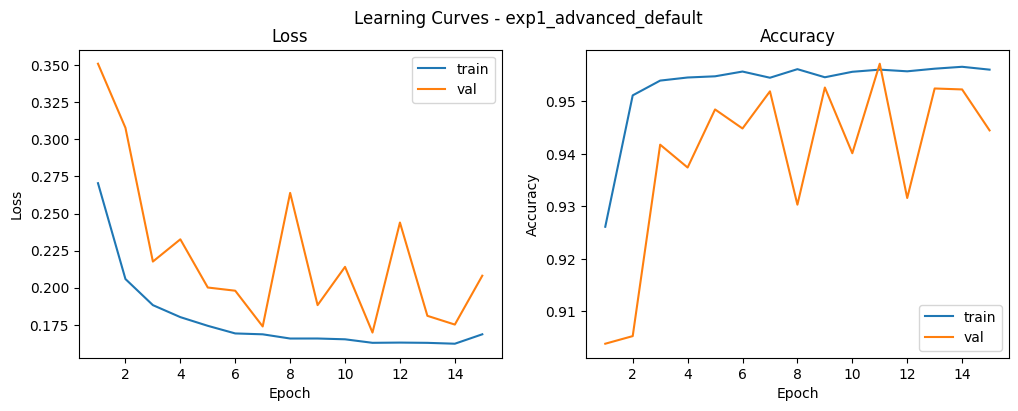

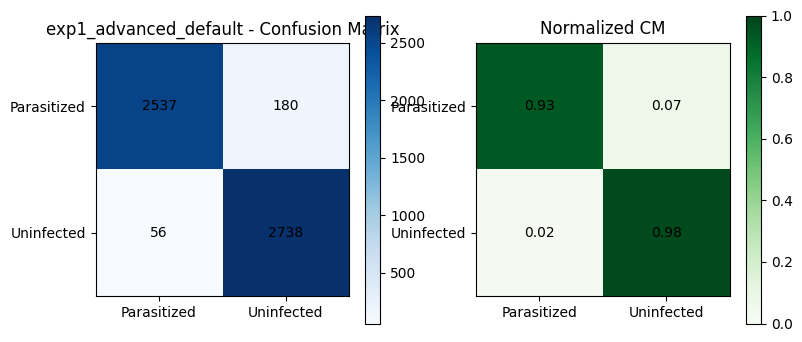

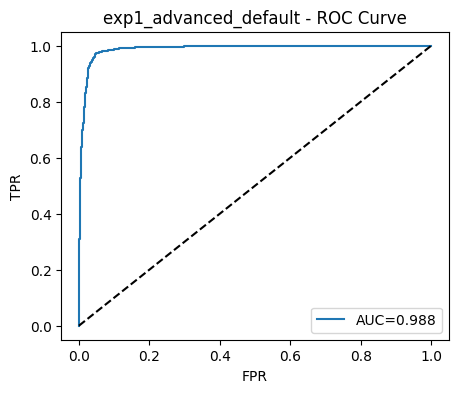

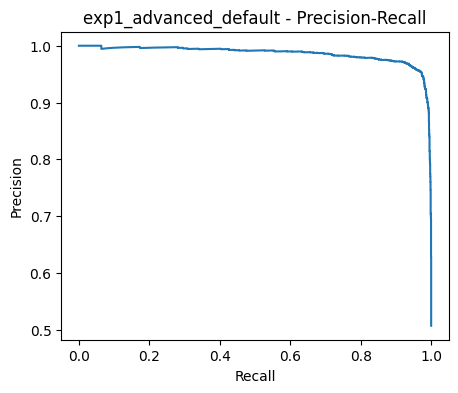

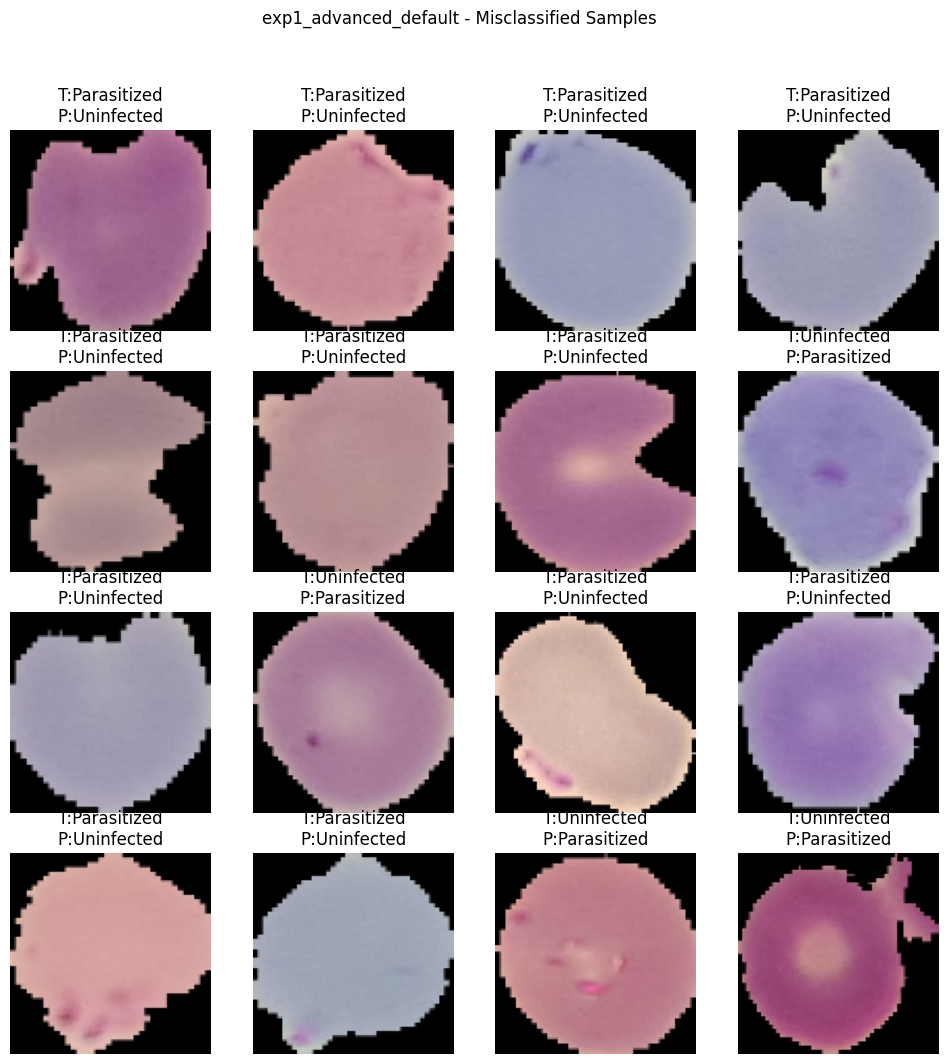

,precision,recall,f1-score,support
Parasitized,0.978403,0.933750,0.955556,2717.000000
Uninfected,0.938314,0.979957,0.958683,2794.000000
accuracy,0.957177,0.957177,0.957177,0.957177
macro avg,0.958359,0.956854,0.957120,5511.000000
weighted avg,0.958079,0.957177,0.957141,5511.000000


Saved classification report to advanced_cnn_figures/exp1_advanced_default_report.csv

=== Running exp2_more_filters ===
Epoch 1/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 80s 105ms/step - accuracy: 0.8436 - loss: 0.4427 - precision: 0.8286 - recall: 0.8685 - val_accuracy: 0.9220 - val_loss: 0.3306 - val_precision: 0.8733 - val_recall: 0.9896
Epoch 2/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 70s 102ms/step - accuracy: 0.9522 - loss: 0.2285 - precision: 0.9410 - recall: 0.9646 - val_accuracy: 0.9463 - val_loss: 0.3525 - val_precision: 0.9486 - val_recall: 0.9452
Epoch 3/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 70s 102ms/step - accuracy: 0.9538 - loss: 0.2071 - precision: 0.9419 - recall: 0.9669 - val_accuracy: 0.9122 - val_loss: 0.3170 - val_precision: 0.8591 - val_recall: 0.9889
Epoch 4/15
689/689 ━━━━━━━━━━━━━━━━━━━━ 70s 101ms/step - accuracy: 0.9525 - loss: 0.1884 - precision: 0.9432 - recall: 0.9626 - val_accuracy: 0.9394 - val_loss: 0.2634 - val_precision: 0.9025 - val_recall: 0.9871
Epoch 5/15
689/689 ━━━━━━━━━

In [ ]:
# Define seven experiment configurations (self-contained)
try:
    OUTPUT_DIR
except NameError:
    OUTPUT_DIR = 'advanced_cnn_figures'
    os.makedirs(OUTPUT_DIR, exist_ok=True)

experiments = [
    {'name': 'exp1_advanced_default', 'epochs': 15, 'lr': 1e-3, 'dropout_rate': 0.3, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 5},
    {'name': 'exp2_more_filters', 'epochs': 15, 'lr': 1e-3, 'dropout_rate': 0.3, 'l2_weight': 1e-4, 'base_filters': 48, 'use_batchnorm': True, 'patience': 5},
    {'name': 'exp3_higher_dropout', 'epochs': 20, 'lr': 1e-3, 'dropout_rate': 0.5, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 6},
    {'name': 'exp4_lower_lr', 'epochs': 20, 'lr': 5e-4, 'dropout_rate': 0.4, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 6},
    {'name': 'exp5_weight_decay', 'epochs': 20, 'lr': 1e-3, 'dropout_rate': 0.4, 'l2_weight': 5e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 6},
    {'name': 'exp6_no_batchnorm', 'epochs': 20, 'lr': 1e-3, 'dropout_rate': 0.4, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': False, 'patience': 6},
    {'name': 'exp7_more_epochs', 'epochs': 30, 'lr': 1e-3, 'dropout_rate': 0.4, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 8},
]

results = []
for cfg in experiments:
    print(f"\n=== Running {cfg['name']} ===")
    metrics, history = run_experiment(cfg, train_ds, val_ds, test_ds, meta)
    row = {'experiment': cfg['name']}
    row.update({k: v for k, v in metrics.items() if isinstance(v, (int, float, np.floating))})
    results.append(row)

results_df = pd.DataFrame(results)
results_df


In [6]:
# Helpers to compute and save full classification report
from sklearn.metrics import classification_report as sk_classification_report

def predict_arrays(model, ds, num_classes: int):
    y_true = []
    y_prob = []
    for images, labels in ds:
        preds = model.predict(images, verbose=0)
        if num_classes == 2:
            y_prob.extend(preds.flatten())
        else:
            y_prob.extend(tf.nn.softmax(preds, axis=-1).numpy())
        y_true.extend(labels.numpy().astype(int))
    y_true = np.array(y_true)
    if num_classes == 2:
        y_prob = np.array(y_prob)
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_prob = np.array(y_prob)
        y_pred = y_prob.argmax(axis=1)
    return y_true, y_pred, y_prob


def save_and_display_classification_report(y_true, y_pred, class_names, csv_path: str):
    report_dict = sk_classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    df.to_csv(csv_path)
    display(df)
    print('Saved classification report to', csv_path)

In [ ]:
# Save results and figures helpers
RESULTS_CSV = 'advanced_cnn_results.csv'

results_df.to_csv(RESULTS_CSV, index=False)
print('Saved table to', RESULTS_CSV)



### Notes for Report and Presentation
- Rationale: deeper feature extractors + augmentation + L2/dropout to reduce overfitting.
- Experiments vary filters, dropout, learning rate, weight decay, batch norm, and epochs.
- Include interpretations of learning curves (over/underfitting), confusion matrix errors, and ROC/AUC trade-offs.
- Compare best advanced CNN run vs baseline CNN in this notebook.
- Cite relevant works on regularization and CNN depth in medical imaging.


In [ ]:
# Figure output directory
OUTPUT_DIR = 'advanced_cnn_figures'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print('Figures will be saved under:', os.path.abspath(OUTPUT_DIR))


## Notebook Roadmap (Advanced CNN)
- Run "One-click pipeline" to perform data loading, train 7 experiments, and save all figures/CSV.
- Use the auto-generated best-experiment summary cell for quick reporting.
- Read the "Methods and Discussion" section (pre-written) and adjust with your exact numbers if desired.


In [ ]:
# One-click pipeline: data -> 7 experiments -> figures + CSV
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64
VAL_SPLIT = 0.2

os.makedirs('advanced_cnn_figures', exist_ok=True)

train_ds, val_ds, test_ds, meta = get_datasets(
    data_dir='cell_images', image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, val_split=VAL_SPLIT, shuffle=True
)

experiments = [
    {'name': 'exp1_advanced_default', 'epochs': 15, 'lr': 1e-3, 'dropout_rate': 0.3, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 5},
    {'name': 'exp2_more_filters', 'epochs': 15, 'lr': 1e-3, 'dropout_rate': 0.3, 'l2_weight': 1e-4, 'base_filters': 48, 'use_batchnorm': True, 'patience': 5},
    {'name': 'exp3_higher_dropout', 'epochs': 20, 'lr': 1e-3, 'dropout_rate': 0.5, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 6},
    {'name': 'exp4_lower_lr', 'epochs': 20, 'lr': 5e-4, 'dropout_rate': 0.4, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 6},
    {'name': 'exp5_weight_decay', 'epochs': 20, 'lr': 1e-3, 'dropout_rate': 0.4, 'l2_weight': 5e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 6},
    {'name': 'exp6_no_batchnorm', 'epochs': 20, 'lr': 1e-3, 'dropout_rate': 0.4, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': False, 'patience': 6},
    {'name': 'exp7_more_epochs', 'epochs': 30, 'lr': 1e-3, 'dropout_rate': 0.4, 'l2_weight': 1e-4, 'base_filters': 32, 'use_batchnorm': True, 'patience': 8},
]

run_rows = []
for cfg in experiments:
    print(f"\n=== Running {cfg['name']} ===")
    metrics, history = run_experiment(cfg, train_ds, val_ds, test_ds, meta)
    flat = {k: v for k, v in metrics.items() if isinstance(v, (int, float, np.floating))}
    flat['experiment'] = cfg['name']
    run_rows.append(flat)

results_df = pd.DataFrame(run_rows)
results_df.to_csv('advanced_cnn_results.csv', index=False)
results_df


In [ ]:
# Best experiment summary
if 'results_df' in globals() and len(results_df) > 0:
    metric_col = 'f1' if 'f1' in results_df.columns else ('f1_macro' if 'f1_macro' in results_df.columns else 'accuracy')
    best_row = results_df.sort_values(metric_col, ascending=False).iloc[0]
    print('Best experiment by', metric_col, ':', best_row['experiment'])
    display(results_df.sort_values(metric_col, ascending=False))
else:
    print('Run the pipeline cell first.')


## Methods and Discussion (Advanced CNN)
- Architecture: three convolutional blocks (double conv + max pool) with BatchNorm, followed by GAP and dense head. Regularization via L2 weight decay and dropout; data augmentation (flip, rotation, zoom) applied on the fly.
- Experiments: varied base filters (32→48), dropout (0.3→0.5), learning rate (1e-3→5e-4), weight decay (1e-4→5e-4), batch norm on/off, and training length. Early stopping monitors validation loss.
- Evaluation: we report accuracy, precision, recall, F1, ROC-AUC; we show learning curves, confusion matrices (raw + normalized), ROC, precision–recall, and a misclassified grid for qualitative error analysis.
- Interpretation: select the best experiment by F1 (or accuracy if F1 unavailable). Discuss over/underfitting symptoms based on loss/accuracy divergence, and tie improvements to regularization/augmentation choices.
- Comparison: contrast the best advanced CNN results against the baseline CNN earlier in the notebook to demonstrate gains.
- Reproducibility: code uses fixed seeds, `tf.data` pipelines with cache/prefetch, and writes `advanced_cnn_results.csv` plus per-experiment figures in `advanced_cnn_figures/`.


In [ ]:
# Helpers to compute and save full classification report
from sklearn.metrics import classification_report as sk_classification_report

def predict_arrays(model, ds, num_classes: int):
    y_true = []
    y_prob = []
    for images, labels in ds:
        preds = model.predict(images, verbose=0)
        if num_classes == 2:
            y_prob.extend(preds.flatten())
        else:
            y_prob.extend(tf.nn.softmax(preds, axis=-1).numpy())
        y_true.extend(labels.numpy().astype(int))
    y_true = np.array(y_true)
    if num_classes == 2:
        y_prob = np.array(y_prob)
        y_pred = (y_prob >= 0.5).astype(int)
    else:
        y_prob = np.array(y_prob)
        y_pred = y_prob.argmax(axis=1)
    return y_true, y_pred, y_prob


def save_and_display_classification_report(y_true, y_pred, class_names, csv_path: str):
    report_dict = sk_classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    df.to_csv(csv_path)
    display(df)
    print('Saved classification report to', csv_path)
